In [1]:
# MAIN FUNCTION

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Taille dans lesquelles vont êtres redimentionnées les photos
width=150
height=150

# Dictionnaire stockant l'ensemble des associations images<->classe
# sur lesquel sera entrainé le model
data = dict()
data['description'] = 'resized ({0}x{1})masked and non masked faces images in rgb'.format(int(width), int(height))
data['label'] = [] #Label of the classes
#data['filename'] = []
data['data'] = [] 
# les images sont stockées dans le tableau associé à la clé 'data'
# les valeurs des classes associées au images sont stockées dans le tableau associé à la clé 'label'
# Pour tout indice n inferieur au nb d'image, l'image data['data'][n] est de la classe data['label'][n]

In [4]:
# Chargement du dataset 'Face Mask Detection' fournis par Kaggle

src="./archive/annotations"

for xmlFile in os.listdir(src):
    # On construit le chemin vers le fichier de nom 'xmlFile'
    current_path=src+"/"+xmlFile

    # On charge le fichier xml courrant dans un dataframe
    df = pd.read_xml(current_path)
    #num_without_mask = df[df['name'].notnull()]['name'].tolist().count("without_mask");
    
    # On retire les lignes du df à None sur leur colonne name,
    # puis on sauvegarde la colonne name du df dans une series
    series_mask = df[df['name'].notnull()]['name']

    # On conserve uniquement les elements de la series differents de "without_mask"
    series_mask = series_mask[series_mask!="without_mask"]

    nb_mask = series_mask.shape[0] # On obtient le nombre de masques portés dans l'image
    if( nb_mask>1 ):
        nb_mask=1
    data['label'].append(nb_mask)

src="./archive/images"

for picture in os.listdir(src):
    # On construit le chemin vers le fichier de nom 'picture'
    current_path=src+"/"+picture

    # On verifie si le fichier actuellement lu est bien une image
    if(picture[-3:] in ['png', 'jpg']):
        # On charge l'image courante en niveaux de gris dans 'img' un tableau numpy
        img = imread(current_path, as_gray=True);

        # scale down the image to one third
        #img = rescale(img, 1/3, mode='reflect')
        #On redimentionne l'image afin d'obtenir un format constant entre toutes les images
        img = resize(img, (width, height)) #[:,:,::-1]
        data['data'].append(img) # On ajoute l'image à la liste des images chargées dans le dictionnaire
        
# Fin de chargement du dataset 'ARCHIVE' fournis par Kaggle

print("Nombre d'images chargées : ", len(data['label']))

Nombre d'images chargées :  3707


In [3]:
# Chargement du dataset 'lfw' fournis pas Kaggle
# ce dataset se divise en sous-repertoires

# On souhaite limiter le nombre d'images à charger -> on ne parcourt que 'limit-max_rep' sous-repertoires
limit_max_rep=2000;
# On utilise un compteur 'cpt'
cpt=0;


src="./lfw/lfw"
# Ce repertoire ne contient que des visages non masqués
for subdir in os.listdir(src):
    # On verifie si le nombre maximum souhaité de
    # repertoire à déjà été parcourru
    if(cpt>=limit_max_rep):
        break;
    if(os.path.isdir(src+"/"+subdir)):
        # On s'assure que subdir designe bien le nom d'un sous-repertoire 
        for picture in os.listdir(src+"/"+subdir):
            # On parcourt le sous repertoire actuel
            # picture contient le nom du fichier courant
            current_path=src+"/"+subdir+"/"+picture;
            
            # On verifie si le fichier actuellement lu est bien une image
            if(picture[-3:] in ['png', 'jpg']):
                img = imread(current_path, as_gray=True);
                # scale down the image to one third
                #img = rescale(img, 1/3, mode='reflect')
                img = resize(img, (width, height)) #[:,:,::-1]
                data['data'].append(img)
                data['label'].append(0)
                cpt = cpt+1;

            
# fin du chargement du dataset'lfw'

print("Nombre d'images chargées : ", len(data['label']))

Nombre d'images chargées :  2854


In [8]:
# Separation du jeu d'images en jeu d'entrainement et jeu de test

from sklearn.model_selection import train_test_split

# Convertion des listes data['data'] et data['label'] en array numpy
X = np.array(data['data'])
##print("X shape :",X.shape)
##print("X[0] shape :", X[0].shape)
y = np.array(data['label'])
##print("Y shape :",y.shape)
##print("Y[0] shape :", y[0].shape)

# Appel de la méthode 'train_test_split' de sklearn pour la separation du dataset en 2
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,      #On place 20% des couples donnée-classe dans le jeu de test, donc 80% dans le jeu d'entrainement
    shuffle=True,       #shuffle permet de melanger les couples donnée-classe de X et y avant d'effectuer la subdivision
    random_state=42,    #On donne la seed pour le shuffle
)

print("Taille du jeu d'entrainement :", X_train.shape)
print("Taille du jeu de tests :", X_test.shape)

MemoryError: Unable to allocate 490. MiB for an array with shape (2854, 150, 150) and data type float64

In [ ]:
# Definition des Transformers

from sklearn.base import BaseEstimator, TransformerMixin

# Transformer convertissant une image en niveaux de gris 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
 # Transformer calculant le HOG d'une image 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [6]:
# Instanciation et utilisation des transformers

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# Creation d'une instance de chaque transformers
# grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14),   # blocs de 14x14 pixels pour le calcul des gradients
    cells_per_block=(2,2), 
    orientations=9,             # calcul des gradients selon 9 orientations
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# Traitement de X_train : appel de fit_transform de chaque transformers sur X_train
#X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print("Jeu de données d'entrainement traité");

NameError: name 'HogTransformer' is not defined

In [ ]:
# Entrainement du modèle

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [ ]:
# Réalisation des tests

#X_test_gray = grayify.transform(X_test) Pictures in X_test already gray
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

# On construit le tableau des resultats prédits par le modèle
y_pred = sgd_clf.predict(X_test_prepared)

# On affiche les indices des images n'ayant pas été correctement
# prédites par le modele
print(np.where(np.array(y_pred == y_test)==False))
print('')

#On affiche le pourcentage de precision du modèle
print('Pourcentage precision: ', 100*np.sum(y_pred == y_test)/len(y_test))

NameError: name 'hogify' is not defined

masque detecté


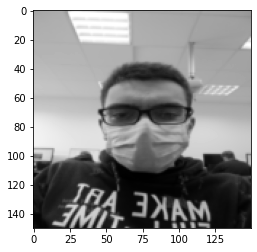

In [ ]:
# Test avec des images externes

#Chemin vers l'image personnalisée
path_testing_img="./testing_pictures/Arnaud_mask_1.jpg"; 

testing_img = imread(path_testing_img, as_gray=True);
testing_img = resize(testing_img, (width, height)) #[:,:,::-1]
plt.imshow(testing_img, cmap="gray")

liste=[]
liste.append(testing_img)
X_img = np.array(liste);

X_img_hog = hogify.transform(X_img)
X_img_prepared = scalify.transform(X_img_hog)

y_pred = sgd_clf.predict(X_img_prepared)

if(y_pred[0]==1) :
    print("masque detecté")
else :
    print("masque nondetecté")